## Movie Similarity using Plot Data
<p>We'll be using previously scraped Wikipedia data. </p>

The Approach:<ul>
<li>Import libraries, load and view the dataset, ensure correct datatypes, convert ?/blanks/etc. into nan etc. </li>
<li>Prepare our data: Prepare features, tokenization, stopword removal, stemming.
<li>Instantiate tf-idf, fit_transform data, cluster data using Kmeans, Elbow Plot, Bar Plot (cluster counts)</li>
<li>Visualization: Calculate similarity disances between samples. Cluster Chart (post T-SNE), Dendrogram</li>
<li>Conclusion</li></ul>

## Initial Data Import
<li>Import libraries, load and view the dataset, ensure correct datatypes, convert ?/blanks/etc. into nan etc.</li>

In [8]:
#Analyze and Import Data
import pandas as pd

#NLP Preprocessing
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.corpus import stopwords

#tf-idf & Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#Visualization & Similarities
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
#Import movies data
movies = pd.read_csv('datasets/movies.csv')

In [3]:
#Remove Col Rank as it is merely an index
movies.drop(columns='rank', inplace=True)

In [4]:
#Inspect df 
movies.head()

,title,genre,wiki_plot,imdb_plot
0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [5]:
#Combine plots for tokenization, 10 are missing imdb plot's. Those samples will just have less words
movies['combined_plot'] = movies['wiki_plot'].astype(str) + movies['imdb_plot'].astype(str)

In [6]:
#Confirm there are no na's
movies['combined_plot'].isna().sum()

0

## Prepare our Data
<li>Prepare features, tokenization, stopword removal, stemming.</li>

In [9]:
#Create preprocessing function to handle tokenization and stemming

#Instantiate stemmer
stemmer = SnowballStemmer('english')

#Define preprocessor function
def preprocessor(string):
    tokens = [word for sent in sent_tokenize(string) for word in word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return stemmed_tokens

#Test function on sample text
words_stemmed = preprocessor("""Today (May 19, 2016) is his only daughter's wedding. Vito Corleone is the Godfather.""")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed', 'vito', 'corleon', 'is', 'the', 'godfath']


## TF-IDF & Clusters
<li>Instantiate tf-idf, fit_transform data, cluster data using Kmeans, calculate similarity disances between samples.</li>

In [10]:
#Instantiate tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=preprocessor,
                                 ngram_range=(1,3))

#max_df : ignore terms with frequency above, we will ignore 80th percentile and above
#max_features : 200000 #maximum amount of features 
#min_df : ignore terms with frequency below , we will ignore 20th percentile and below
#stopwords : 'english' 
#ngram_range : tuple (start, end) #unigrams, bigrams and trigrams
#Tokenizer : our custom function

In [11]:
#Fit & Transform
tf_idf_matrix = tfidf_vectorizer.fit_transform(movies['combined_plot'])
tf_idf_matrix.shape

C:\Users\saisu\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


(100, 564)

In [12]:
#Prepare elbow graph using kmeans clustering algo
x = list(range(1, 6))
y = []

for i in x:
    km = KMeans(n_clusters=i, random_state=45)
    km.fit(tf_idf_matrix)
    y.append(km.inertia_)

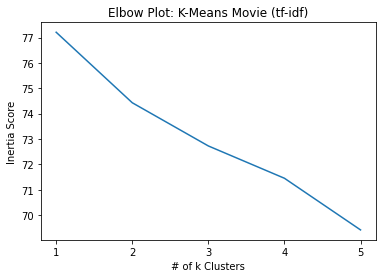

In [13]:
#Plot elbow graph using pyplot
ax = plt.subplot()
plt.plot(x, y)
ax.set_xticks(x)
plt.title('Elbow Plot: K-Means Movie (tf-idf)')
plt.xlabel('# of k Clusters')
plt.ylabel('Inertia Score')
plt.show()
#Our graph does not converge but this is still okay, as movies can't definitively apart but are similar.
#i.e. it makes sense that movies continue to separate with more clusters

In [14]:
#Fit KMeans with 5 clusters and append to dataframe
km = KMeans(n_clusters=5, random_state=45)
km.fit(tf_idf_matrix)

movies['cluster'] = km.labels_

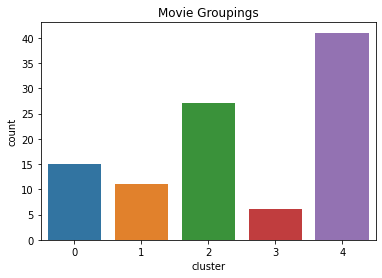

In [15]:
#Plot groupings using seaborn countplot
sns.countplot(x=movies.cluster)
plt.title('Movie Groupings')
plt.show()

## Visualization
<li>Visualization: calculate similarity disances between samples. Cluster Chart (post PCA), Dendrogram</li>

<b>Part 1</b>: Cosine Similiarty, Helper Functions and a new DataFrame

In [16]:
#Build cosine score's DF #We use cosine since our vectors (features) are not uniform length. (e.g. can't use Euclidean)
cosine_scores = pd.DataFrame(cosine_similarity(tf_idf_matrix), columns=movies.title)

In [17]:
#Set Index as movie title
cosine_scores.set_index(movies.title, inplace=True)
cosine_scores.head()
#Naturally movies are perfectly similar with themselves

title,The Godfather,The Shawshank Redemption,Schindler's List,Raging Bull,Casablanca,One Flew Over the Cuckoo's Nest,Gone with the Wind,Citizen Kane,The Wizard of Oz,Titanic,...,The Maltese Falcon,A Clockwork Orange,Taxi Driver,Wuthering Heights,Double Indemnity,Rebel Without a Cause,Rear Window,The Third Man,North by Northwest,Yankee Doodle Dandy
title,,,,,,,,,,,,,,,,,,,,,
The Godfather,1.000000,0.199353,0.237059,0.244951,0.265143,0.201050,0.420543,0.259238,0.279268,0.124768,...,0.365210,0.256076,0.270553,0.202496,0.335475,0.335643,0.226727,0.359780,0.329244,0.175979
The Shawshank Redemption,0.199353,1.000000,0.266522,0.174568,0.232103,0.294216,0.264903,0.191957,0.223140,0.127963,...,0.278430,0.470019,0.201265,0.165730,0.187303,0.118932,0.182120,0.266451,0.228391,0.107025
Schindler's List,0.237059,0.266522,1.000000,0.186793,0.289593,0.213408,0.395412,0.228596,0.218661,0.162518,...,0.203889,0.207909,0.225345,0.160774,0.199577,0.099950,0.182654,0.275747,0.250510,0.141327
Raging Bull,0.244951,0.174568,0.186793,1.000000,0.176206,0.175528,0.283852,0.308186,0.127767,0.123147,...,0.181292,0.219611,0.254896,0.196218,0.186779,0.177407,0.203804,0.234472,0.230521,0.123112
Casablanca,0.265143,0.232103,0.289593,0.176206,1.000000,0.305734,0.339547,0.246137,0.261153,0.118198,...,0.328186,0.217580,0.265010,0.183721,0.385051,0.217032,0.233644,0.394144,0.367966,0.195792


In [18]:
#Create function to make comparisons
def compare(cosine_scores, movie1, movie2):
    movies = cosine_scores.columns
    if movie1 not in movies: 
        return f'Data is not available for {movie1} please select another movie'
    elif movie2 not in movies:
        return f'Data is not available for {movie2} please select another movie'
        
    score = cosine_scores[movie1].loc[movie2]
    return score

In [19]:
#Confirm our comparison function is working
assert compare(cosine_scores, 'The Godfather', 'Raging Bull') == 0.24495080529938248, 'not getting right value'
assert compare(cosine_scores, 'The Matrix', 'Raging Bull') == 'Data is not available for The Matrix please select another movie', 'Function should have stopped'
assert compare(cosine_scores, 'The Godfather', 'Spider-Man') == 'Data is not available for Spider-Man please select another movie', 'Function should have stopped'

In [20]:
#Create function to return the movie with the highest similarity to another movie that is not itself
def most(cosine_scores, movie):
    movies = cosine_scores.columns
    if movie not in movies: 
        return f'Data is not available for {movie} please select another movie'
    new_df = cosine_scores.drop(movie)
    idx_max = new_df[movie].idxmax()
    return idx_max

In [21]:
#Confirm our most similar function is working
assert most(cosine_scores, 'Batman') == 'Data is not available for Batman please select another movie', 'Function might think Batman is there?'
assert most(cosine_scores, 'The Godfather') != 'Data is not available for The Godfather please select another movie', 'Godfather should return movie'
assert most(cosine_scores, 'The Godfather') != 'The Godfather', 'A movie should not return itself'

In [22]:
#Create a function to return the top n similar movies to another movie, excluding itself
def top_n(cosine_scores, movie, n):
    movies = cosine_scores.columns
    if movie not in movies: 
        return f'Data is not available for {movie} please select another movie'
    new_df = cosine_scores.drop(movie)[movie].sort_values(ascending=False)
    top_n = new_df[:n]
    return top_n

In [23]:
#Confirm our top (n) function is working
assert top_n(cosine_scores, 'Batman', 1) == 'Data is not available for Batman please select another movie', 'Function might think Batman is there?'
assert top_n(cosine_scores, 'Godfather', 1) != 'Data is not available for The Godfather please select another movie', 'Godfather should return movie'
assert top_n(cosine_scores, 'Star Wars', 1).index != 'Star Wars', 'A movie should not return itself'

In [24]:
#Build a new DF using our function to check our similarities
movie_relation = pd.DataFrame(movies.title)
#Add the movie most similar in a column called 'closest'
closest = [most(cosine_scores, movie) for movie in movies.title]
movie_relation['closest'] = closest

In [25]:
#Add the next two subsequent movies in similiarity in a col called 2nd_3rd
top_3 = [top_n(cosine_scores, movie, 3) for movie in movies.title]
top_3 = [list(x.index)[1:] for x in top_3]
movie_relation['2nd_3rd'] = top_3

In [26]:
#Inspect
movie_relation.head(10)

,title,closest,2nd_3rd
0,The Godfather,The Godfather: Part II,"[Goodfellas, Giant]"
1,The Shawshank Redemption,A Clockwork Orange,"[Goodfellas, The Bridge on the River Kwai]"
2,Schindler's List,The Pianist,"[Doctor Zhivago, Gone with the Wind]"
3,Raging Bull,The Godfather: Part II,"[Rocky, Rain Man]"
4,Casablanca,From Here to Eternity,"[The Third Man, Double Indemnity]"
5,One Flew Over the Cuckoo's Nest,A Clockwork Orange,"[North by Northwest, Platoon]"
6,Gone with the Wind,The Best Years of Our Lives,"[Doctor Zhivago, The Deer Hunter]"
7,Citizen Kane,The Godfather: Part II,"[Annie Hall, Tootsie]"
8,The Wizard of Oz,E.T. the Extra-Terrestrial,"[Gone with the Wind, Ben-Hur]"
9,Titanic,Star Wars,"[Vertigo, 2001: A Space Odyssey]"


In [27]:
#As we can see this does make sense as the Godfather has the most in common with its sequel 
#Gone with the Wind & another romance classic etc.
#Some movies are off as function of a small dataset (only 100 so titanic goes w Star Wars)

<b>Part 2</b>: Cluster Chart using T-SNE (as PCA won't work on sparse matrices)

In [28]:
#Our cluster that never converged can be plotted first
#Perform Dimensionality Reduction using TSNE
tsne = TSNE(2, random_state=42)
matrix = tsne.fit_transform(tf_idf_matrix)

C:\Users\saisu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\saisu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [29]:
#Fit this 2-dimensional to KMeans algo
km = KMeans(5, random_state=45)
km.fit(matrix)

C:\Users\saisu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=45)

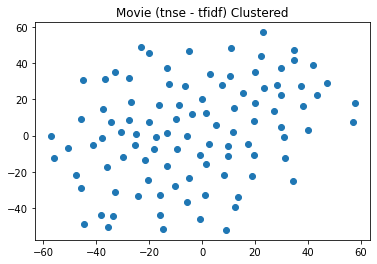

In [30]:
#We can plot how our data looks, as we can see some points are closer than others but the data is overall very dispersed.
#Hence why we never converged (we can still cluster to get similarities) #As movies in the same group are more similar 
#than in a different group
plt.scatter(matrix[:, 0], matrix[:, 1])
plt.title('Movie (tnse - tfidf) Clustered')
plt.show()

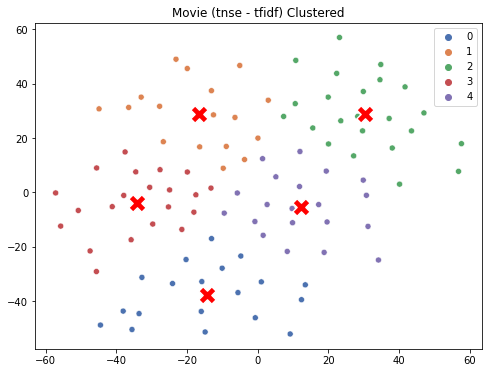

In [31]:
#Replot our data with different colors to show our clustering
#Plot our centroids with big X's
plt.figure(figsize=(8,6))
sns.scatterplot(x=matrix[:, 0], y=matrix[:, 1], hue=km.labels_, palette='deep')
sns.scatterplot(x=km.cluster_centers_[:, 0], color= 'red', y=km.cluster_centers_[:, 1], marker='X', s=300)
plt.title('Movie (tnse - tfidf) Clustered')
plt.show()

<b>Part 3</b>: Dendrogram

In [32]:
#Get cosine similarities to build our Dendrogram
similarities = cosine_similarity(tf_idf_matrix)

In [33]:
#Before we use our dendrogram, we'll use sklearn's linkage function to outline
mergings = linkage(similarities, method='complete')

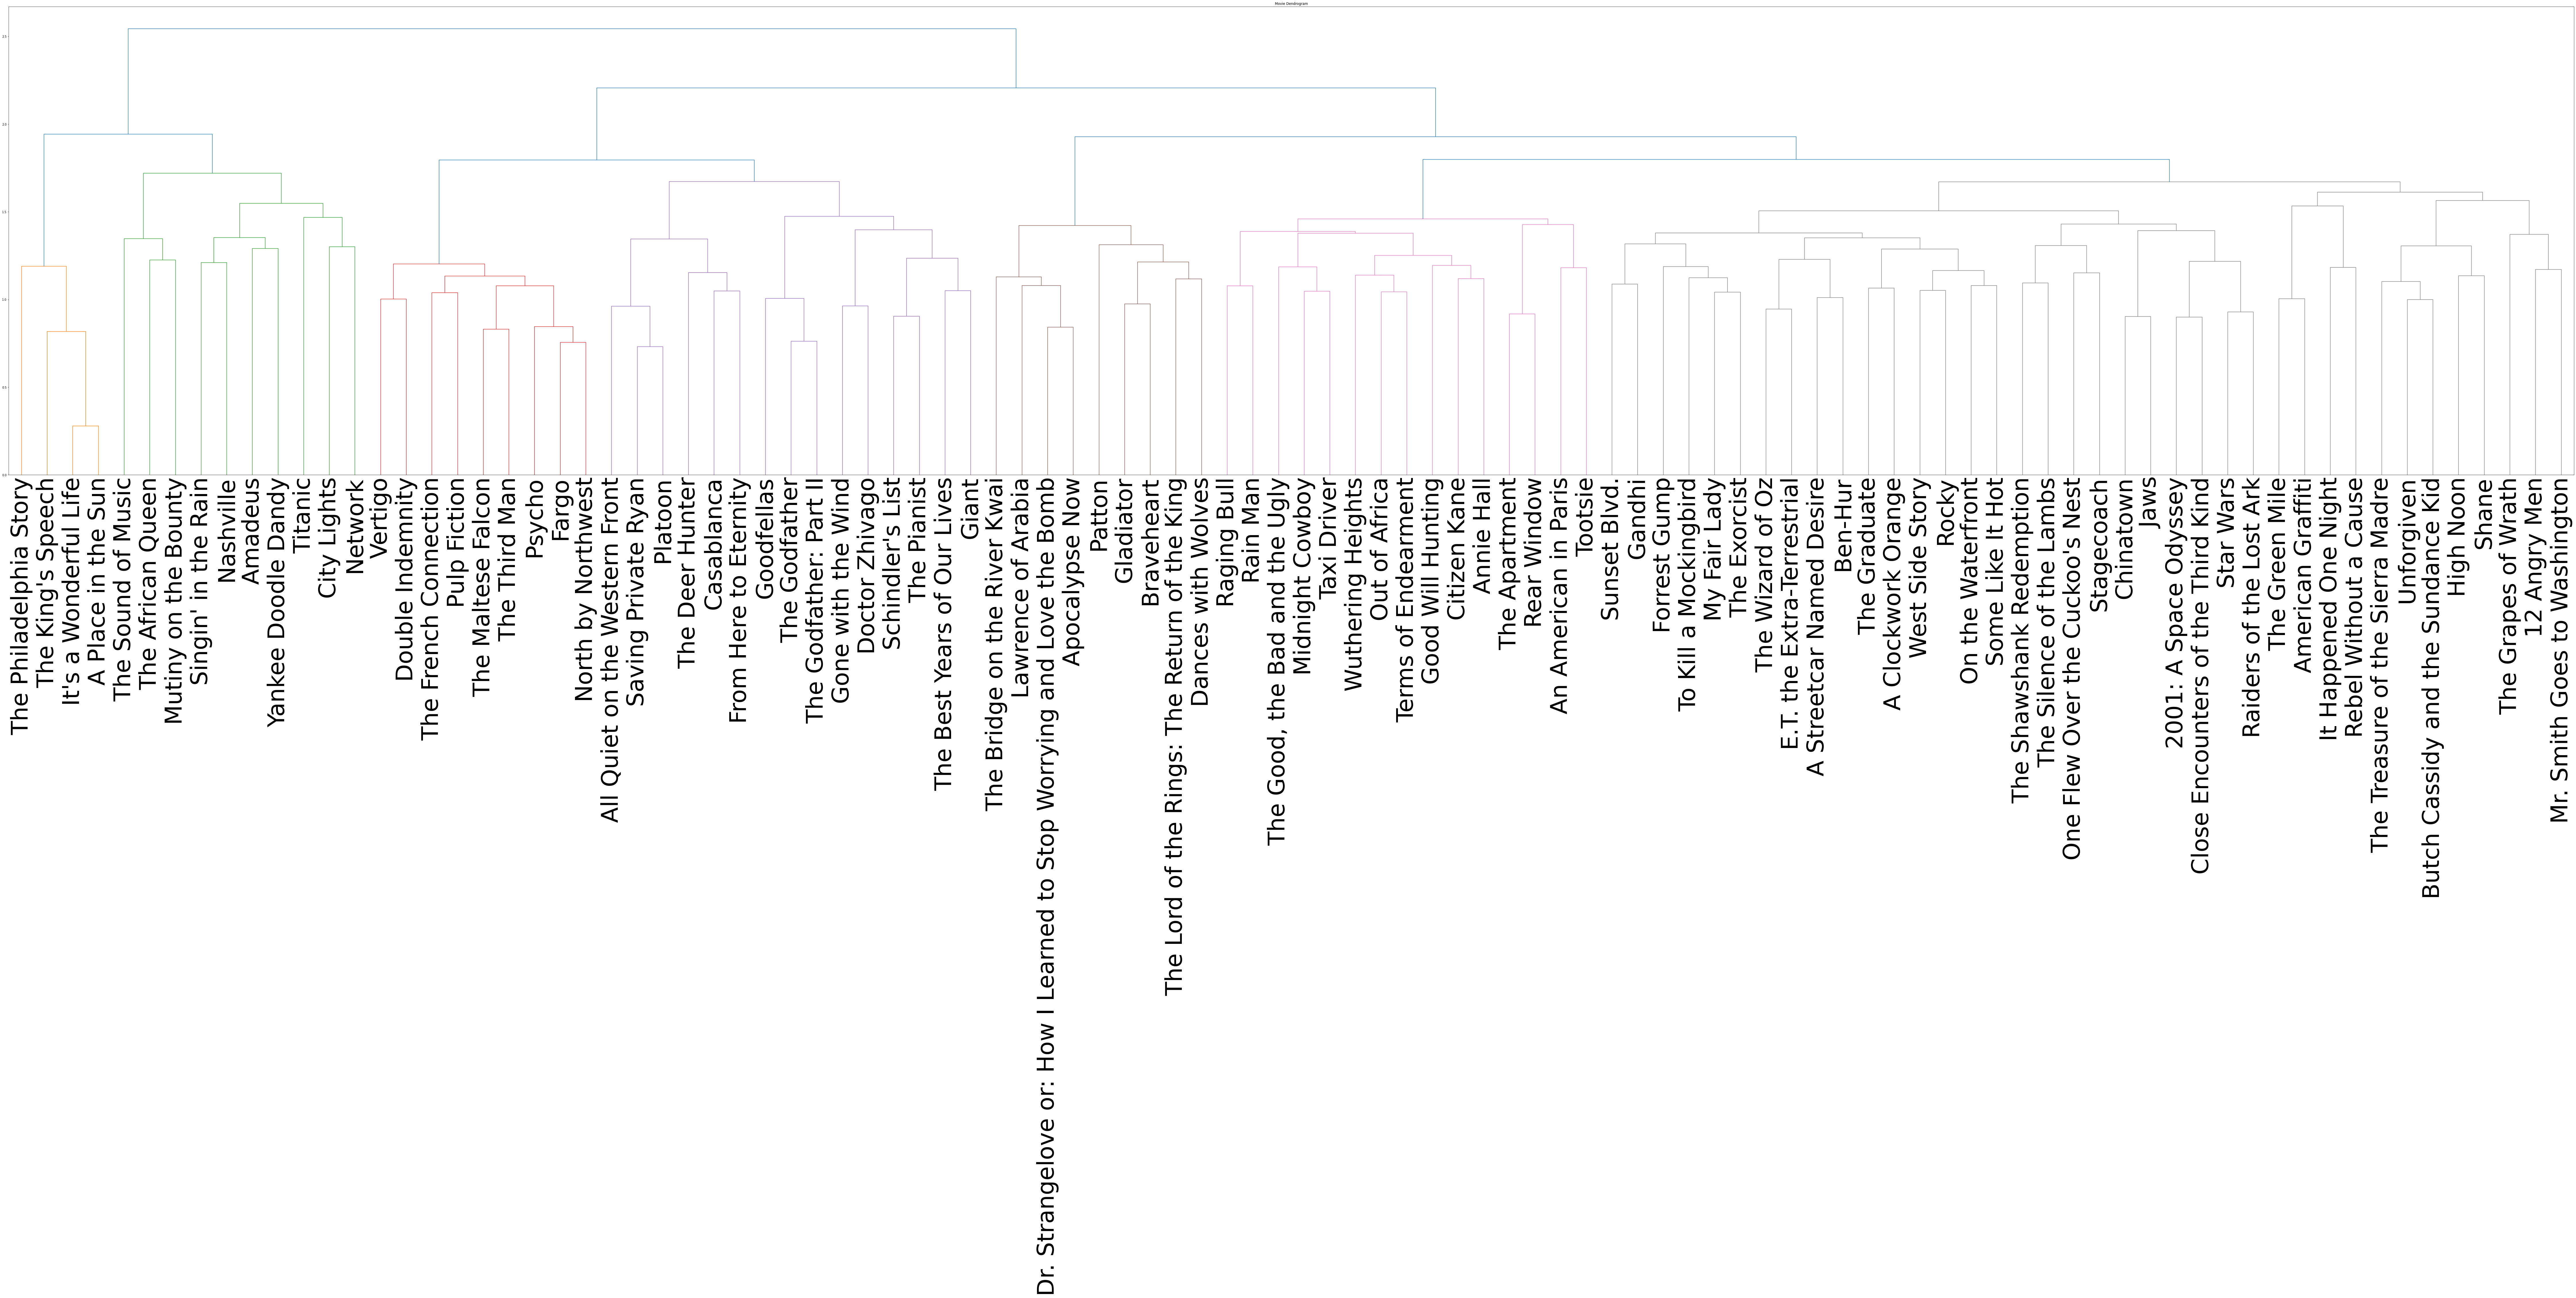

In [34]:
#Plot dendrogram using mergings, our movie titles as labels
dendrogram_ = dendrogram(mergings, labels=movies.title.values, leaf_rotation=90, leaf_font_size=16)

#Get current figure and set it's size and labels to black
fig = plt.gcf()
_ = [lbl.set_color('black') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(160, 30)
#Get current figure's axes and set them larger
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=80)


# Show the plotted dendrogram
plt.title('Movie Dendrogram')
plt.show()

## Conclusion
<li>Check a specific movie's similarities. Consider differences in simple cosine distance and our Dendrogram.</li>

In [35]:
#The GodFather

# First we'll use our Dendrogram, visually we can grab the most similar movie
godfather_dendrogram = ['godfather 2', 'goodfellas']

#Next we can use our custom functions
godfather_most_similar = top_n(cosine_scores, 'The Godfather', 3)
godfather_most_similar


title
The Godfather: Part II    0.621888
Goodfellas                0.520691
Giant                     0.462301
Name: The Godfather, dtype: float64

In [36]:
#Discrepancies
#Why may our Dendrogram be more accurate than our functions, which us simply cosine scores?
#Our Dendrogram factors in the entire dataset, while our functions just look up a specific movie.

In [37]:
#For example when we inspect Braveheart, the Godfather and Gone with the Wind come up in it's top 3.
#But both those movies have movies that are more* in common (Godfather 2 for example)
#So our Dendrogram puts Braveheart next to Gladiator & LOTR instead (which is a lot more fitting)
Braveheart_most_similar = top_n(cosine_scores, 'Braveheart', 10)
Braveheart_most_similar
#Other Thoughts:
#Could transform our scatter plot using bokeh and add a hover and visually see movies that are similar.

title
Gladiator                                        0.458678
Gone with the Wind                               0.395959
The Godfather                                    0.344387
The Lord of the Rings: The Return of the King    0.320370
Dances with Wolves                               0.312520
The Godfather: Part II                           0.312047
Patton                                           0.309006
To Kill a Mockingbird                            0.307987
On the Waterfront                                0.295494
The Exorcist                                     0.292303
Name: Braveheart, dtype: float64